# New methos for mobius optimization

In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # for 3D projection
import os
import time
plt.style.use('_mpl-gallery')
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [3]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [4]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


In [ ]:
import numpy as np
import time
import copy

# Hill Climbing parameters
max_iterations = 100
step_size = 0.1
tolerance = 1e-6
num_restarts = 5  # Multiple random starts

# Fixed hyperparameters (you can adjust these)
p_val = 1.
q_val = 2.
sim = S2  # your similarity measure
choquet_version = 'linear'
verbose = True
eval_type = 'loo'  # using LOO as specified
sim_agent = 'mobius'

print("Starting Hill Climbing optimization for single Möbius measure...")
start_time = time.time()

# Store best results across all restarts
global_best_mobius = None
global_best_accuracy = -float('inf')
global_best_history = []

for restart in range(num_restarts):
    print(f"\n--- Restart {restart + 1}/{num_restarts} ---")

    # Initialize random starting point
    if len(lst_mobius) > 0:
        # Start from a random Möbius measure in your list
        current_mobius = copy.deepcopy(lst_mobius[np.random.randint(len(lst_mobius))])
    else:
        print("Warning: lst_mobius is empty, you need to initialize Möbius measures")
        continue

    # Evaluate initial Möbius measure
    current_fitness = fitness_function(
        capacities_list=[current_mobius],  # Single Möbius in a list
        DS=(data, labels),
        sim=sim,
        choquet_version=choquet_version,
        p=p_val,
        q=q_val,
        verbose=False,
        eval_type=eval_type,
        sim_agent=sim_agent
    )[0]
    
    current_accuracy = -current_fitness  # Convert back to accuracy
    
    print(f"Initial accuracy: {current_accuracy:.4f}")
    
    # Hill climbing iterations
    iteration_history = [current_accuracy]
    
    for iteration in range(max_iterations):
        improved = False
        best_neighbor = None
        best_neighbor_accuracy = current_accuracy
        
        # Generate neighbors by perturbing the Möbius measure
        neighbors = []
        
        # Create neighbors by adding/subtracting step_size to each Capacity element
        for i in range(len(current_mobius)):
            # For each Capacity element in the Möbius measure
            for direction in [-1, 1]:
                neighbor_mobius = copy.deepcopy(current_mobius)
                
                # Perturb the mu value (which is a single float in Capacity class)
                perturbation = direction * step_size * np.random.uniform(0.5, 1.5)
                neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                
                # Ensure mu values stay within valid bounds [0, 1]
                neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
                
                neighbors.append(neighbor_mobius)
        
        # Also try perturbing all elements simultaneously (global perturbation)
        for direction in [-1, 1]:
            neighbor_mobius = copy.deepcopy(current_mobius)
            for i in range(len(neighbor_mobius)):
                perturbation = direction * step_size * np.random.uniform(0.1, 0.3)
                neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
            neighbors.append(neighbor_mobius)
        
        # Evaluate all neighbors
        if neighbors:
            # Evaluate each neighbor individually
            neighbor_accuracies = []
            for neighbor in neighbors:
                try:
                    neighbor_fitness = fitness_function(
                        capacities_list=[neighbor],  # Single neighbor in a list
                        DS=(data, labels),
                        sim=sim,
                        choquet_version=choquet_version,
                        p=p_val,
                        q=q_val,
                        verbose=False,
                        eval_type=eval_type,
                        sim_agent=sim_agent
                    )[0]
                    neighbor_accuracies.append(-neighbor_fitness)  # Convert to accuracy
                except:
                    neighbor_accuracies.append(-float('inf'))  # Penalize invalid neighbors
            
            # Find best neighbor
            best_neighbor_idx = np.argmax(neighbor_accuracies)
            best_neighbor_accuracy = neighbor_accuracies[best_neighbor_idx]
            
            # Check if we found an improvement
            if best_neighbor_accuracy > current_accuracy + tolerance:
                current_mobius = neighbors[best_neighbor_idx]
                current_accuracy = best_neighbor_accuracy
                improved = True
                
                if verbose and iteration % 5 == 0:
                    print(f"Iteration {iteration}: Accuracy improved to {current_accuracy:.4f}")
        
        iteration_history.append(current_accuracy)
        
        # Stop if no improvement
        if not improved:
            print(f"Converged at iteration {iteration}")
            break
        
        # Adaptive step size (optional)
        if iteration > 10 and len(iteration_history) > 5:
            recent_improvement = iteration_history[-1] - iteration_history[-6]
            if recent_improvement < tolerance:
                step_size *= 0.9  # Reduce step size if improvement is slow
                if verbose:
                    print(f"Reduced step size to {step_size:.4f}")
    
    print(f"Final accuracy for restart {restart + 1}: {current_accuracy:.4f}")
    
    # Update global best
    if current_accuracy > global_best_accuracy:
        global_best_accuracy = current_accuracy
        global_best_mobius = copy.deepcopy(current_mobius)
        global_best_history = iteration_history.copy()

end_time = time.time()
print(f"\n=== Hill Climbing Results ===")
print(f"Best accuracy found: {global_best_accuracy:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")

# Optional: Plot convergence
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(global_best_history)
    plt.title('Hill Climbing Convergence - Single Möbius Optimization')
    plt.xlabel('Iteration')
    plt.ylabel('LOO Accuracy')
    plt.grid(True)
    plt.show()
    print("Convergence plot displayed")
except ImportError:
    print("Matplotlib not available for plotting")

# Store results
hill_climbing_best_mobius = global_best_mobius
hill_climbing_best_accuracy = global_best_accuracy

print(f"\nOptimized Möbius measure stored in: hill_climbing_best_mobius")
print(f"Best LOO accuracy stored in: hill_climbing_best_accuracy")

# # Compare with your grid search results if available
# if len(best_accuracies) > 0:
#     grid_search_best = max(best_accuracies)
#     print(f"\nComparison:")
#     print(f"Grid Search best LOO accuracy: {grid_search_best:.4f}")
#     print(f"Hill Climbing best LOO accuracy: {hill_climbing_best_accuracy:.4f}")
#     print(f"Improvement: {hill_climbing_best_accuracy - grid_search_best:.4f}")

# Test the optimized Möbius measure
print(f"\n=== Testing Optimized Möbius ===")
bst_acc = mobius_to_capacity(hill_climbing_best_mobius, features)
final_acc = FuzzLOO(
    DS=(data, labels),
    mu=bst_acc,
    sim=S2,
    choquet_version='d_choquet',
    p=p_val,
    q=q_val,
)

final_test_accuracy = final_acc
print(f"Final verification - LOO accuracy: {final_test_accuracy:.4f}")
print(f"Best LOO accuracy from hill climbing: {hill_climbing_best_accuracy:.4f}")

Starting Hill Climbing optimization for single Möbius measure...

--- Restart 1/5 ---
Initial accuracy: 0.6600
Iteration 0: Accuracy improved to 0.7333


In [ ]:
# Test the optimized Möbius measure
print(f"\n=== Testing Optimized Möbius ===")
bst_acc = mobius_to_capacity(hill_climbing_best_mobius, features)
final_acc = FuzzLOO(
    DS=(data, labels),
    mu=bst_acc,
    sim=S2,
    choquet_version='d_choquet',
    p=p_val,
    q=q_val,
    # verbose=True,
    # eval_type=eval_type,
    # sim_agent=sim_agent
)

final_test_accuracy = final_acc
print(f"Final verification - LOO accuracy: {final_test_accuracy:.4f}")
print(f"Best LOO accuracy from hill climbing: {hill_climbing_best_accuracy:.4f}")


=== Testing Optimized Möbius ===
Final verification - LOO accuracy: 0.4467
Best LOO accuracy from hill climbing: 0.8533


Starting Hill Climbing optimization for single Möbius measure...

--- Restart 1/5 ---
Initial accuracy: 0.3667
Iteration 0: Accuracy improved to 0.6400
Converged at iteration 1
Final accuracy for restart 1: 0.6400

--- Restart 2/5 ---
Initial accuracy: 0.6400
Converged at iteration 0
Final accuracy for restart 2: 0.6400

--- Restart 3/5 ---
Initial accuracy: 0.6400
Iteration 0: Accuracy improved to 0.6467
Converged at iteration 1
Final accuracy for restart 3: 0.6467

--- Restart 4/5 ---
Initial accuracy: 0.6467
Converged at iteration 0
Final accuracy for restart 4: 0.6467

--- Restart 5/5 ---
Initial accuracy: 0.6467
Converged at iteration 0
Final accuracy for restart 5: 0.6467

=== Hill Climbing Results ===
Best accuracy found: 0.6467
Total time: 414.46 seconds


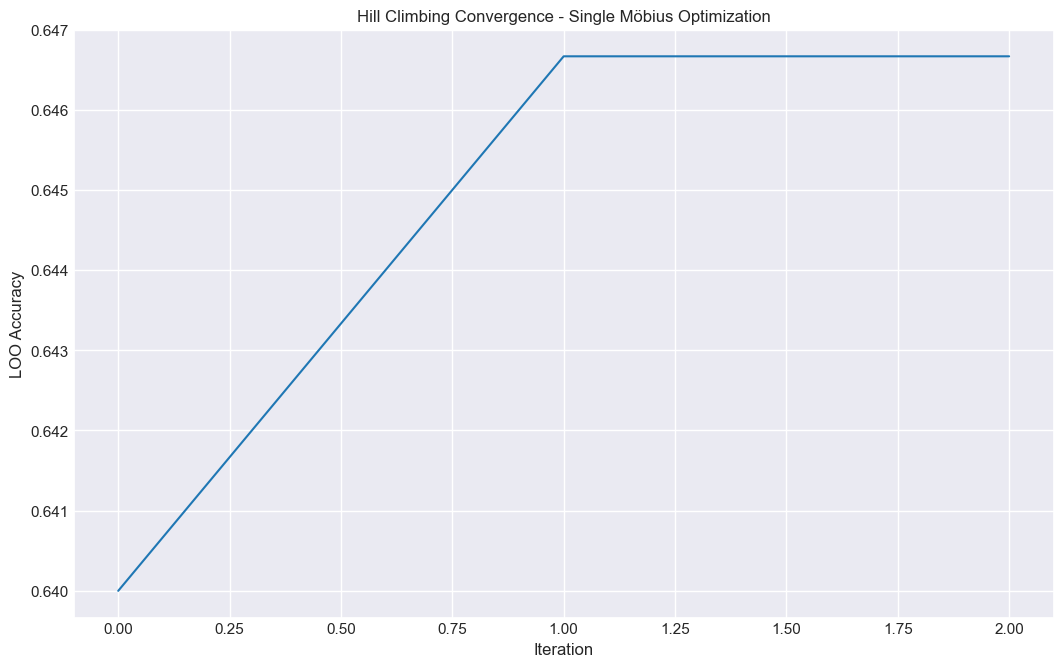

Convergence plot displayed

Optimized Möbius measure stored in: hill_climbing_best_mobius
Best LOO accuracy stored in: hill_climbing_best_accuracy

=== Testing Optimized Möbius ===
Processing capacity 1/1...
Capacities 1: [np.float64(0.0), np.float64(0.17024130167983823), np.float64(0.05656929584128006), np.float64(0.10600978291078128), np.float64(0.08266795704544631), np.float64(0.34740672168699005), np.float64(0.34294482569964263), np.float64(0.34393109566809277), np.float64(0.1159993861958375), np.float64(0.24198599546885266), np.float64(0.3949116115031117), np.float64(0.5589796438108957), np.float64(0.6238452582573709), np.float64(0.6812164393066207), np.float64(0.46599790544213354), np.float64(1.0)]
Accuracy: 0.6467

Final verification - LOO accuracy: 0.6467


In [ ]:
import numpy as np
import time
import copy

# Hill Climbing parameters
max_iterations = 100
step_size = 0.1
tolerance = 1e-6
num_restarts = 5  # Multiple random starts

# Fixed hyperparameters (you can adjust these)
p_val = 0.25
q_val = 1.0
sim = S2  # your similarity measure
choquet_version = 'd_choquet'
verbose = True
eval_type = 'loo'  # using LOO as specified
sim_agent = 'mobius'

print("Starting Hill Climbing optimization for single Möbius measure...")
start_time = time.time()

# Store best results across all restarts
global_best_mobius = None
global_best_accuracy = -float('inf')
global_best_history = []

# Initialize random starting point
if len(capacities_list) > 0:
    # Start from a random Möbius measure in your list
    current_mobius = copy.deepcopy(capacities_list[np.random.randint(len(capacities_list))])
else:
    print("Warning: capacities_list is empty, you need to initialize Möbius measures")

for restart in range(num_restarts):
    print(f"\n--- Restart {restart + 1}/{num_restarts} ---")
    
    # Evaluate initial Möbius measure
    current_fitness = fitness_function(
        capacities_list=[current_mobius],  # Single Möbius in a list
        DS=(data, labels),
        sim=sim,
        choquet_version=choquet_version,
        p=p_val,
        q=q_val,
        verbose=False,
        eval_type=eval_type,
        sim_agent=sim_agent
    )[0]
    
    current_accuracy = -current_fitness  # Convert back to accuracy
    
    print(f"Initial accuracy: {current_accuracy:.4f}")
    
    # Hill climbing iterations
    iteration_history = [current_accuracy]
    
    for iteration in range(max_iterations):
        improved = False
        best_neighbor = None
        best_neighbor_accuracy = current_accuracy
        
        # Generate neighbors by perturbing the Möbius measure
        neighbors = []
        
        # Create neighbors by adding/subtracting step_size to each Capacity element
        for i in range(len(current_mobius)):
            # For each Capacity element in the Möbius measure
            for direction in [-1, 1]:
                neighbor_mobius = copy.deepcopy(current_mobius)
                
                # Perturb the mu value (which is a single float in Capacity class)
                perturbation = direction * step_size * np.random.uniform(0.5, 1.5)
                neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                
                # Ensure mu values stay within valid bounds [0, 1]
                neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
                
                neighbors.append(neighbor_mobius)
        
        # Also try perturbing all elements simultaneously (global perturbation)
        for direction in [-1, 1]:
            neighbor_mobius = copy.deepcopy(current_mobius)
            for i in range(len(neighbor_mobius)):
                perturbation = direction * step_size * np.random.uniform(0.1, 0.3)
                neighbor_mobius[i].mu = neighbor_mobius[i].mu + perturbation
                neighbor_mobius[i].mu = np.clip(neighbor_mobius[i].mu, 0, 1)
            neighbors.append(neighbor_mobius)
        
        # Evaluate all neighbors
        if neighbors:
            # Evaluate each neighbor individually
            neighbor_accuracies = []
            for neighbor in neighbors:
                try:
                    neighbor_fitness = fitness_function(
                        capacities_list=[neighbor],  # Single neighbor in a list
                        DS=(data, labels),
                        sim=sim,
                        choquet_version=choquet_version,
                        p=p_val,
                        q=q_val,
                        verbose=False,
                        eval_type=eval_type,
                        sim_agent=sim_agent
                    )[0]
                    neighbor_accuracies.append(-neighbor_fitness)  # Convert to accuracy
                except:
                    neighbor_accuracies.append(-float('inf'))  # Penalize invalid neighbors
            
            # Find best neighbor
            best_neighbor_idx = np.argmax(neighbor_accuracies)
            best_neighbor_accuracy = neighbor_accuracies[best_neighbor_idx]
            
            # Check if we found an improvement
            if best_neighbor_accuracy > current_accuracy + tolerance:
                current_mobius = neighbors[best_neighbor_idx]
                current_accuracy = best_neighbor_accuracy
                improved = True
                
                if verbose and iteration % 5 == 0:
                    print(f"Iteration {iteration}: Accuracy improved to {current_accuracy:.4f}")
        
        iteration_history.append(current_accuracy)
        
        # Stop if no improvement
        if not improved:
            print(f"Converged at iteration {iteration}")
            break
        
        # Adaptive step size (optional)
        if iteration > 10 and len(iteration_history) > 5:
            recent_improvement = iteration_history[-1] - iteration_history[-6]
            if recent_improvement < tolerance:
                step_size *= 0.9  # Reduce step size if improvement is slow
                if verbose:
                    print(f"Reduced step size to {step_size:.4f}")
    
    print(f"Final accuracy for restart {restart + 1}: {current_accuracy:.4f}")
    
    # Update global best
    if current_accuracy > global_best_accuracy:
        global_best_accuracy = current_accuracy
        global_best_mobius = copy.deepcopy(current_mobius)
        global_best_history = iteration_history.copy()

end_time = time.time()
print(f"\n=== Hill Climbing Results ===")
print(f"Best accuracy found: {global_best_accuracy:.4f}")
print(f"Total time: {end_time - start_time:.2f} seconds")

# Optional: Plot convergence
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(global_best_history)
    plt.title('Hill Climbing Convergence - Single Möbius Optimization')
    plt.xlabel('Iteration')
    plt.ylabel('LOO Accuracy')
    plt.grid(True)
    plt.show()
    print("Convergence plot displayed")
except ImportError:
    print("Matplotlib not available for plotting")

# Store results
hill_climbing_best_mobius = global_best_mobius
hill_climbing_best_accuracy = global_best_accuracy

print(f"\nOptimized Möbius measure stored in: hill_climbing_best_mobius")
print(f"Best LOO accuracy stored in: hill_climbing_best_accuracy")

# # Compare with your grid search results if available
# if len(best_accuracies) > 0:
#     grid_search_best = max(best_accuracies)
#     print(f"\nComparison:")
#     print(f"Grid Search best LOO accuracy: {grid_search_best:.4f}")
#     print(f"Hill Climbing best LOO accuracy: {hill_climbing_best_accuracy:.4f}")
#     print(f"Improvement: {hill_climbing_best_accuracy - grid_search_best:.4f}")

# Test the optimized Möbius measure
print(f"\n=== Testing Optimized Möbius ===")
final_test_fitness = fitness_function(
    capacities_list=[hill_climbing_best_mobius],
    DS=(data, labels),
    sim=sim,
    choquet_version=choquet_version,
    p=p_val,
    q=q_val,
    verbose=True,
    eval_type=eval_type,
    sim_agent=sim_agent
)[0]

final_test_accuracy = -final_test_fitness
print(f"Final verification - LOO accuracy: {final_test_accuracy:.4f}")

```txt
===================================================
 HILL CLIMBING OPTIMIZATION - GENERALIZED OVERVIEW
===================================================

1. Initialization Phase
------------------------
- Define algorithm parameters:
    • max_iterations
    • step_size
    • tolerance
    • num_restarts (for multiple starting points)
- Set fixed hyperparameters for evaluation (e.g., p, q, similarity type)
- Initialize best global result variables
- Choose initial candidate solution (random or predefined)

2. Multi-Restart Loop (Repeat N times)
--------------------------------------
For each restart:
  a. Evaluate the initial solution's performance (fitness)
  b. Start iterative hill climbing search

3. Hill Climbing Iteration Loop
-------------------------------
For each iteration:
  a. Generate neighbors of the current solution:
      • Perturb each parameter individually
      • Optionally perturb all parameters globally
  b. Clip or validate perturbed values (e.g., mu in [0, 1])
  c. Evaluate each neighbor's fitness
  d. Select the best neighbor
  e. If it improves over the current solution:
      • Update current solution
      • Record improvement

  f. Optional: Adaptive step size adjustment
     • If recent improvements are minimal, reduce step size

  g. Stop if no improvement (convergence)

4. After Each Restart
----------------------
- Compare result with the best so far
- Save if it's better than previous best

5. Post Optimization
---------------------
- Report the best result from all restarts
- Optionally visualize the convergence (e.g., plot accuracy over iterations)
- Re-evaluate final solution for verification

===============================================
     END OF GENERALIZED HILL CLIMBING FLOW
===============================================```